In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from patsy import dmatrices
import statsmodels.api as sm
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.base import clone
%matplotlib inline

In [2]:
# Import each dataset
math_df = pd.read_csv('student-mat.csv', sep=';')
port_df = pd.read_csv('student-por.csv', sep=';')

In [3]:
# Get list of column/feature names for each
m_cols = math_df.columns
p_cols = port_df.columns

In [4]:
# Check if columns in each are identical
(m_cols == p_cols).all()

True

In [5]:
cols = list(m_cols)

In [6]:
# Remove the variables that differentiate Portuguese/Math students
for col in ['G1', 'G2', 'G3']:
    cols.remove(col)

In [7]:
# Make a merged dataframe of rows with features values that are identical across P/M
# AKA... DataFrame of students who are in BOTH classes
both_df = math_df.merge(port_df, left_on = cols, right_on = cols)
# --> 39 rows (students in both), 36 columns

both_df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,Dalc,Walc,health,absences,G1_x,G2_x,G3_x,G1_y,G2_y,G3_y
0,GP,M,16,U,LE3,T,2,2,other,other,...,1,1,3,0,12,12,11,13,12,13
1,GP,M,15,U,GT3,A,2,2,other,other,...,1,1,3,0,14,16,16,14,14,15
2,GP,M,15,U,GT3,T,4,3,teacher,other,...,1,1,1,0,13,14,15,12,13,14
3,GP,M,15,U,GT3,T,4,4,health,health,...,1,1,5,0,12,15,15,11,12,12
4,GP,M,15,U,GT3,T,4,4,health,services,...,3,4,5,0,9,11,12,10,11,11


In [8]:
math_only_df = pd.merge(math_df, both_df, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)
print(math_only_df.shape)
math_only_df.head()

(356, 39)


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,absences,G1,G2,G3,G1_x,G2_x,G3_x,G1_y,G2_y,G3_y
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,6,5,6,6,NaN,NaN,NaN,NaN,NaN,NaN
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,4,5,5,6,NaN,NaN,NaN,NaN,NaN,NaN
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,10,7,8,10,NaN,NaN,NaN,NaN,NaN,NaN
3,GP,F,15,U,GT3,T,4,2,health,services,...,2,15,14,15,NaN,NaN,NaN,NaN,NaN,NaN
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,6,10,10,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
port_only_df = pd.merge(port_df, both_df, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)
print(port_only_df.shape)
port_only_df.head()

(610, 39)


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,absences,G1,G2,G3,G1_x,G2_x,G3_x,G1_y,G2_y,G3_y
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,0,11,11,NaN,NaN,NaN,NaN,NaN,NaN
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,2,9,11,11,NaN,NaN,NaN,NaN,NaN,NaN
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,6,12,13,12,NaN,NaN,NaN,NaN,NaN,NaN
3,GP,F,15,U,GT3,T,4,2,health,services,...,0,14,14,14,NaN,NaN,NaN,NaN,NaN,NaN
4,GP,F,16,U,GT3,T,3,3,other,other,...,0,11,13,13,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
port_only_df['math'] = 0
port_only_df['port'] = 1
port_only_df['both'] = 0

port_only_df['math_G1'] = 0
port_only_df['port_G1'] = port_only_df['G1']
port_only_df['math_G2'] = 0
port_only_df['port_G2'] = port_only_df['G2']
port_only_df['math_G3'] = 0
port_only_df['port_G3'] = port_only_df['G3']

math_only_df['math'] = 0
math_only_df['port'] = 1
math_only_df['both'] = 0

math_only_df['math_G1'] = math_only_df['G1']
math_only_df['port_G1'] = 0
math_only_df['math_G2'] = math_only_df['G2']
math_only_df['port_G2'] = 0
math_only_df['math_G3'] = math_only_df['G3']
math_only_df['port_G3'] = 0

both_df['math'] = 1
both_df['port'] = 1
both_df['both'] = 1

both_df['math_G1'] = both_df['G1_x']
both_df['port_G1'] = both_df['G1_y']
both_df['math_G2'] = both_df['G2_x']
both_df['port_G2'] = both_df['G2_y']
both_df['math_G3'] = both_df['G3_x']
both_df['port_G3'] = both_df['G3_y']

In [11]:
nln_both = ['G1_x', 'G2_x', 'G3_x', 'G1_y', 'G2_y', 'G3_y']

port_only_df.drop(nln_both, axis=1, inplace=True)
math_only_df.drop(nln_both, axis=1, inplace=True)
both_df.drop(nln_both, axis=1, inplace=True)

In [12]:
one_more = ['G1', 'G2', 'G3']

port_only_df.drop(one_more, axis=1, inplace=True)
math_only_df.drop(one_more, axis=1, inplace=True)

In [13]:
# Check!
print(both_df.shape)
print(port_only_df.shape)
print(math_only_df.shape)

port_only_df.shape[0] + math_only_df.shape[0] + both_df.shape[0]

(39, 39)
(610, 39)
(356, 39)


1005

In [14]:
# Add unique id for each row
firstpoint = both_df.shape[0] + 1
midpoint = port_only_df.shape[0] + firstpoint
lastpoint = math_only_df.shape[0] + midpoint

both_df['id'] = range(1, firstpoint)
port_only_df['id'] = range(firstpoint,  midpoint)
math_only_df['id'] = range(midpoint, lastpoint)

In [15]:
joined_df = both_df.append(port_only_df.append(math_only_df, ignore_index=True, sort=False), ignore_index=True, sort=False)
joined_df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,math,port,both,math_G1,port_G1,math_G2,port_G2,math_G3,port_G3,id
0,GP,M,16,U,LE3,T,2,2,other,other,...,1,1,1,12,13,12,12,11,13,1
1,GP,M,15,U,GT3,A,2,2,other,other,...,1,1,1,14,14,16,14,16,15,2
2,GP,M,15,U,GT3,T,4,3,teacher,other,...,1,1,1,13,12,14,13,15,14,3
3,GP,M,15,U,GT3,T,4,4,health,health,...,1,1,1,12,11,15,12,15,12,4
4,GP,M,15,U,GT3,T,4,4,health,services,...,1,1,1,9,10,11,11,12,11,5


In [19]:
joined_df['id'].unique().size

1005

In [20]:
joined_df.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'math', 'port', 'both', 'math_G1',
       'port_G1', 'math_G2', 'port_G2', 'math_G3', 'port_G3', 'id'],
      dtype='object')

In [21]:
# Now, let's make a copy... just in case!
df = joined_df.copy()
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,math,port,both,math_G1,port_G1,math_G2,port_G2,math_G3,port_G3,id
0,GP,M,16,U,LE3,T,2,2,other,other,...,1,1,1,12,13,12,12,11,13,1
1,GP,M,15,U,GT3,A,2,2,other,other,...,1,1,1,14,14,16,14,16,15,2
2,GP,M,15,U,GT3,T,4,3,teacher,other,...,1,1,1,13,12,14,13,15,14,3
3,GP,M,15,U,GT3,T,4,4,health,health,...,1,1,1,12,11,15,12,15,12,4
4,GP,M,15,U,GT3,T,4,4,health,services,...,1,1,1,9,10,11,11,12,11,5


In [32]:
cont_df = joined_df.iloc[:, 30:-1]
cont_df.head()
cont_df['age'] = joined_df['age']
cont_df['absences'] = joined_df['absences']
cont_df.head()

,math,port,both,math_G1,port_G1,math_G2,port_G2,math_G3,port_G3,age,absences
0,1,1,1,12,13,12,12,11,13,16,0
1,1,1,1,14,14,16,14,16,15,15,0
2,1,1,1,13,12,14,13,15,14,15,0
3,1,1,1,12,11,15,12,15,12,15,0
4,1,1,1,9,10,11,11,12,11,15,0


In [34]:
non_cont_vars = joined_df.columns[:30]
non_cont_vars

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences'],
      dtype='object')

In [37]:
binary_vars = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']
categorical_vars = ['Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health']

age
absences


In [38]:
b_df = df[binary_vars]
b_df.head()

,school,sex,address,famsize,Pstatus,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic
0,GP,M,U,LE3,T,no,no,no,no,yes,yes,yes,no
1,GP,M,U,GT3,A,no,yes,no,no,yes,yes,yes,yes
2,GP,M,U,GT3,T,no,no,no,no,yes,yes,yes,no
3,GP,M,U,GT3,T,no,yes,yes,no,yes,yes,yes,no
4,GP,M,U,GT3,T,no,yes,yes,no,no,yes,yes,no


In [41]:
# Making function so that I can do this easily for PORT data
def convert_dummies(df, col_name, encoding_dict):
    # Make dictionary for individual col values
    col_dict = dict()
    # Grab unique values for given column
    unique_vals = df[col_name].unique()
    # Sort 'em
    unique_vals.sort()
    # If the first (of two) values is in this list is one of these...
    if unique_vals[0] in ['no', 'F', 'R']:
        # Then we'll encode the second value to equal 1 (first is baseline)
        df[col_name] = (df[col_name] == unique_vals[1]).astype(int)
        # Add this info to individual column's disctionary
        col_dict[unique_vals[0]] = 0
        col_dict[unique_vals[1]] = 1
    # Do opposite (switch 1 and 0) for columns with other values
    else:
        df[col_name] = (df[col_name] == unique_vals[0]).astype(int)
        col_dict[unique_vals[0]] = 1
        col_dict[unique_vals[1]] = 0
    # Add the column name and its encoding dictionary to the larger dictionary, so we can keep track of baseline values
    encoding_dict[col_name] = col_dict

In [42]:
# Make a copy, just in case, and then an overarching conversion_dict to hold our encoding info
encoding_dict = dict()

# Run this for every binary feature in our dummies dataframe
for col in binary_vars:
    convert_dummies(b_df, col, encoding_dict)

# Print resulting encoding dictionary to make sure it's correctly specified
print(encoding_dict)
# Take a look at the df and check if it's looking right
b_df.head()

/Users/tsandefer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


{'school': {'GP': 1, 'MS': 0}, 'sex': {'F': 0, 'M': 1}, 'address': {'R': 0, 'U': 1}, 'famsize': {'GT3': 1, 'LE3': 0}, 'Pstatus': {'A': 1, 'T': 0}, 'schoolsup': {'no': 0, 'yes': 1}, 'famsup': {'no': 0, 'yes': 1}, 'paid': {'no': 0, 'yes': 1}, 'activities': {'no': 0, 'yes': 1}, 'nursery': {'no': 0, 'yes': 1}, 'higher': {'no': 0, 'yes': 1}, 'internet': {'no': 0, 'yes': 1}, 'romantic': {'no': 0, 'yes': 1}}


,school,sex,address,famsize,Pstatus,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic
0,1,1,1,0,0,0,0,0,0,1,1,1,0
1,1,1,1,1,1,0,1,0,0,1,1,1,1
2,1,1,1,1,0,0,0,0,0,1,1,1,0
3,1,1,1,1,0,0,1,1,0,1,1,1,0
4,1,1,1,1,0,0,1,1,0,0,1,1,0


In [39]:
cat_df = df[categorical_vars]
cat_df.head()

,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health
0,2,2,other,other,home,mother,1,2,0,4,4,4,1,1,3
1,2,2,other,other,home,other,1,3,0,4,5,2,1,1,3
2,4,3,teacher,other,reputation,mother,1,2,0,4,4,1,1,1,1
3,4,4,health,health,other,father,1,1,0,5,4,2,1,1,5
4,4,4,health,services,home,mother,1,2,0,5,4,2,3,4,5


In [43]:
# Make multi-value dummy dataframes
def make_dummy_df(df, categorical_vars):
    # Create empty list that we can insert dummy dataframes into - iterate through to join w/ main df - pick all but last column (One-Hot Encoding)
    dummy_df_lst = []
    # Iterate through list of column names we've picked out
    for col in categorical_vars:
        dummy_df = pd.get_dummies(df[col], prefix=col)
        dummy_df_lst.append(dummy_df)
    # Now, iterate through the list of dummy dataframes and join each (EXCEPT for the last column - as per One-Hot Encoding) to the main df
    baselines = []
    for dummy_df in dummy_df_lst:
        # Append last column to list of baselines for future reference
        baselines.append(dummy_df.columns[0])
        df = df.join(dummy_df.iloc[:, 1:])
    df.drop(columns=categorical_vars, axis=1, inplace=True)
    return baselines, df

# Examine baselines
baselines, cat_df = make_dummy_df(cat_df, categorical_vars)
print(baselines)
cat_df.head()

['Medu_0', 'Fedu_0', 'Mjob_at_home', 'Fjob_at_home', 'reason_course', 'guardian_father', 'traveltime_1', 'studytime_1', 'failures_0', 'famrel_1', 'freetime_1', 'goout_1', 'Dalc_1', 'Walc_1', 'health_1']


,Medu_1,Medu_2,Medu_3,Medu_4,Fedu_1,Fedu_2,Fedu_3,Fedu_4,Mjob_health,Mjob_other,...,Dalc_4,Dalc_5,Walc_2,Walc_3,Walc_4,Walc_5,health_2,health_3,health_4,health_5
0,0,1,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,0,1,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,1,0,0,0,1,1,0,...,0,0,0,0,1,0,0,0,0,1


In [51]:
full_df = cont_df.join(b_df.join(cat_df))
full_df.head()

,math,port,both,math_G1,port_G1,math_G2,port_G2,math_G3,port_G3,age,...,Dalc_4,Dalc_5,Walc_2,Walc_3,Walc_4,Walc_5,health_2,health_3,health_4,health_5
0,1,1,1,12,13,12,12,11,13,16,...,0,0,0,0,0,0,0,1,0,0
1,1,1,1,14,14,16,14,16,15,15,...,0,0,0,0,0,0,0,1,0,0
2,1,1,1,13,12,14,13,15,14,15,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,12,11,15,12,15,12,15,...,0,0,0,0,0,0,0,0,0,1
4,1,1,1,9,10,11,11,12,11,15,...,0,0,0,0,1,0,0,0,0,1


In [52]:
full_df.shape

(1005, 78)

In [53]:
full_df.columns

Index(['math', 'port', 'both', 'math_G1', 'port_G1', 'math_G2', 'port_G2',
       'math_G3', 'port_G3', 'age', 'absences', 'school', 'sex', 'address',
       'famsize', 'Pstatus', 'schoolsup', 'famsup', 'paid', 'activities',
       'nursery', 'higher', 'internet', 'romantic', 'Medu_1', 'Medu_2',
       'Medu_3', 'Medu_4', 'Fedu_1', 'Fedu_2', 'Fedu_3', 'Fedu_4',
       'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher',
       'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher',
       'reason_home', 'reason_other', 'reason_reputation', 'guardian_mother',
       'guardian_other', 'traveltime_2', 'traveltime_3', 'traveltime_4',
       'studytime_2', 'studytime_3', 'studytime_4', 'failures_1', 'failures_2',
       'failures_3', 'famrel_2', 'famrel_3', 'famrel_4', 'famrel_5',
       'freetime_2', 'freetime_3', 'freetime_4', 'freetime_5', 'goout_2',
       'goout_3', 'goout_4', 'goout_5', 'Dalc_2', 'Dalc_3', 'Dalc_4', 'Dalc_5',
       'Walc_2', 'Walc_3', 'Walc_4', 'Walc_5

In [198]:
# Removing: ['romantic', 'math_G1', 'port_G1', 'math_G2', 'port_G2', 'both']
X_cols = ['math', 'port', 'math_G3', 'port_G3', 'age', 'absences', 'school', 'sex', 'address',
       'famsize', 'Pstatus', 'schoolsup', 'famsup', 'paid', 'activities',
       'nursery', 'higher', 'internet', 'Medu_1', 'Medu_2',
       'Medu_3', 'Medu_4', 'Fedu_1', 'Fedu_2', 'Fedu_3', 'Fedu_4',
       'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher',
       'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher',
       'reason_home', 'reason_other', 'reason_reputation', 'guardian_mother',
       'guardian_other', 'traveltime_2', 'traveltime_3', 'traveltime_4',
       'studytime_2', 'studytime_3', 'studytime_4', 'failures_1', 'failures_2',
       'failures_3', 'famrel_2', 'famrel_3', 'famrel_4', 'famrel_5',
       'freetime_2', 'freetime_3', 'freetime_4', 'freetime_5', 'goout_2',
       'goout_3', 'goout_4', 'goout_5', 'Dalc_2', 'Dalc_3', 'Dalc_4', 'Dalc_5',
       'Walc_2', 'Walc_3', 'Walc_4', 'Walc_5', 'health_2', 'health_3',
       'health_4', 'health_5']

y_col = 'romantic'

In [199]:
#SPLIT DATA: TRAIN + HOLDOUT
X = full_df[X_cols]
y = full_df[y_col]

X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

X_train = sm.add_constant(X_train)

In [200]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_holdout.shape)
print(y_holdout.shape)

(643, 72)
(643,)
(161, 72)
(161,)
(201, 72)
(201,)


In [201]:
X_train.columns

Index(['math', 'port', 'math_G3', 'port_G3', 'age', 'absences', 'school',
       'sex', 'address', 'famsize', 'Pstatus', 'schoolsup', 'famsup', 'paid',
       'activities', 'nursery', 'higher', 'internet', 'Medu_1', 'Medu_2',
       'Medu_3', 'Medu_4', 'Fedu_1', 'Fedu_2', 'Fedu_3', 'Fedu_4',
       'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher',
       'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher',
       'reason_home', 'reason_other', 'reason_reputation', 'guardian_mother',
       'guardian_other', 'traveltime_2', 'traveltime_3', 'traveltime_4',
       'studytime_2', 'studytime_3', 'studytime_4', 'failures_1', 'failures_2',
       'failures_3', 'famrel_2', 'famrel_3', 'famrel_4', 'famrel_5',
       'freetime_2', 'freetime_3', 'freetime_4', 'freetime_5', 'goout_2',
       'goout_3', 'goout_4', 'goout_5', 'Dalc_2', 'Dalc_3', 'Dalc_4', 'Dalc_5',
       'Walc_2', 'Walc_3', 'Walc_4', 'Walc_5', 'health_2', 'health_3',
       'health_4', 'health_5'],
      dtype=

In [202]:
X_test.columns

Index(['math', 'port', 'math_G3', 'port_G3', 'age', 'absences', 'school',
       'sex', 'address', 'famsize', 'Pstatus', 'schoolsup', 'famsup', 'paid',
       'activities', 'nursery', 'higher', 'internet', 'Medu_1', 'Medu_2',
       'Medu_3', 'Medu_4', 'Fedu_1', 'Fedu_2', 'Fedu_3', 'Fedu_4',
       'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher',
       'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher',
       'reason_home', 'reason_other', 'reason_reputation', 'guardian_mother',
       'guardian_other', 'traveltime_2', 'traveltime_3', 'traveltime_4',
       'studytime_2', 'studytime_3', 'studytime_4', 'failures_1', 'failures_2',
       'failures_3', 'famrel_2', 'famrel_3', 'famrel_4', 'famrel_5',
       'freetime_2', 'freetime_3', 'freetime_4', 'freetime_5', 'goout_2',
       'goout_3', 'goout_4', 'goout_5', 'Dalc_2', 'Dalc_3', 'Dalc_4', 'Dalc_5',
       'Walc_2', 'Walc_3', 'Walc_4', 'Walc_5', 'health_2', 'health_3',
       'health_4', 'health_5'],
      dtype=

In [203]:
model = LogisticRegression()
model.fit(X_train, y_train)

/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [204]:
y_hat_probs = model.predict_proba(X_test)[:, 1]

threshold = 0.5

y_hat = (y_hat_probs >= threshold).astype(int)

mse = rss(y_test, y_hat)
print("MSE for LogisticRegression: {}".format(mse))

MSE for LogisticRegression: 0.35403726708074534


In [243]:
X_train.columns

Index(['math', 'port', 'math_G3', 'port_G3', 'age', 'absences', 'school',
       'sex', 'address', 'famsize', 'Pstatus', 'schoolsup', 'famsup', 'paid',
       'activities', 'nursery', 'higher', 'internet', 'Medu_1', 'Medu_2',
       'Medu_3', 'Medu_4', 'Fedu_1', 'Fedu_2', 'Fedu_3', 'Fedu_4',
       'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher',
       'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher',
       'reason_home', 'reason_other', 'reason_reputation', 'guardian_mother',
       'guardian_other', 'traveltime_2', 'traveltime_3', 'traveltime_4',
       'studytime_2', 'studytime_3', 'studytime_4', 'failures_1', 'failures_2',
       'failures_3', 'famrel_2', 'famrel_3', 'famrel_4', 'famrel_5',
       'freetime_2', 'freetime_3', 'freetime_4', 'freetime_5', 'goout_2',
       'goout_3', 'goout_4', 'goout_5', 'Dalc_2', 'Dalc_3', 'Dalc_4', 'Dalc_5',
       'Walc_2', 'Walc_3', 'Walc_4', 'Walc_5', 'health_2', 'health_3',
       'health_4', 'health_5'],
      dtype=

In [241]:
X_train['port_G3'].head()

487    10
126    10
364    14
966     0
499    10
Name: port_G3, dtype: int64

In [264]:
X_train_OLS = X_train.copy()
y_train_OLS = X_train_OLS['port_G3']
X_train_OLS.drop(['math_G3', 'port_G3'], axis=1, inplace=True)
X_train_OLS['romantic'] = y_train.copy()


X_test_OLS = X_test.copy()
y_test_OLS = X_test_OLS['port_G3']
X_test_OLS.drop(['math_G3', 'port_G3'], axis=1, inplace=True)
X_test_OLS['romantic'] = y_test.copy()

print(X_train_OLS.columns)
print(y_train_OLS)

print(X_test_OLS.columns)
print(y_test_OLS)

Index(['math', 'port', 'age', 'absences', 'school', 'sex', 'address',
       'famsize', 'Pstatus', 'schoolsup', 'famsup', 'paid', 'activities',
       'nursery', 'higher', 'internet', 'Medu_1', 'Medu_2', 'Medu_3', 'Medu_4',
       'Fedu_1', 'Fedu_2', 'Fedu_3', 'Fedu_4', 'Mjob_health', 'Mjob_other',
       'Mjob_services', 'Mjob_teacher', 'Fjob_health', 'Fjob_other',
       'Fjob_services', 'Fjob_teacher', 'reason_home', 'reason_other',
       'reason_reputation', 'guardian_mother', 'guardian_other',
       'traveltime_2', 'traveltime_3', 'traveltime_4', 'studytime_2',
       'studytime_3', 'studytime_4', 'failures_1', 'failures_2', 'failures_3',
       'famrel_2', 'famrel_3', 'famrel_4', 'famrel_5', 'freetime_2',
       'freetime_3', 'freetime_4', 'freetime_5', 'goout_2', 'goout_3',
       'goout_4', 'goout_5', 'Dalc_2', 'Dalc_3', 'Dalc_4', 'Dalc_5', 'Walc_2',
       'Walc_3', 'Walc_4', 'Walc_5', 'health_2', 'health_3', 'health_4',
       'health_5', 'romantic'],
      dtype='object')


In [265]:
# Train
#X_train_OLS = sm.add_constant(X_train_OLS)
X_train_OLS['constant'] = 1


model = sm.OLS(y_train_OLS, X_train_OLS)
results = model.fit()

fitted_vals = results.predict(X_train_OLS)
stu_resid = results.resid_pearson
residuals = results.resid
#y_vals = pd.DataFrame({'residuals':residuals, 'fitted_vals':fitted_vals, 'stu_resid': stu_resid})
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                port_G3   R-squared:                       0.391
Model:                            OLS   Adj. R-squared:                  0.317
Method:                 Least Squares   F-statistic:                     5.249
Date:                Wed, 13 Feb 2019   Prob (F-statistic):           3.31e-30
Time:                        12:49:59   Log-Likelihood:                -1932.2
No. Observations:                 643   AIC:                             4006.
Df Residuals:                     572   BIC:                             4323.
Df Model:                          70                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
math                  3.7718      1.00

,math,port,age,absences,school,sex,address,famsize,Pstatus,schoolsup,...,Walc_2,Walc_3,Walc_4,Walc_5,health_2,health_3,health_4,health_5,romantic,constant
math,1.000000,NaN,-0.084660,-0.080429,0.041358,0.056418,0.009045,0.008676,-0.019316,0.014322,...,-0.078157,-0.030509,-0.009874,-0.008027,-0.036812,0.016088,0.010968,-0.029456,-0.020134,NaN
port,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,-0.084660,NaN,1.000000,0.152003,-0.180043,-0.054350,-0.110458,-0.022467,-0.014802,-0.227379,...,-0.015620,0.061457,0.054952,0.052684,0.041411,0.080769,-0.010336,-0.073266,0.176512,NaN
absences,-0.080429,NaN,0.152003,1.000000,0.146389,0.008997,0.003885,0.026918,0.153424,-0.043614,...,-0.066807,0.037596,0.111468,0.076330,0.022990,0.030009,-0.037082,0.001048,0.043418,NaN
school,0.041358,NaN,-0.180043,0.146389,1.000000,0.082819,0.333284,0.027950,0.030828,0.139265,...,-0.088955,0.011327,-0.029623,0.031420,-0.049535,-0.000132,0.048290,0.039676,-0.102899,NaN
sex,0.056418,NaN,-0.054350,0.008997,0.082819,1.000000,0.040353,-0.106084,-0.060741,-0.111336,...,-0.115834,0.010421,0.220228,0.240138,0.018477,-0.033970,-0.016479,0.128989,-0.146359,NaN
address,0.009045,NaN,-0.110458,0.003885,0.333284,0.040353,1.000000,-0.033466,0.052350,0.059292,...,-0.097187,0.011327,0.031135,-0.050374,-0.016311,0.016808,-0.045348,-0.011130,-0.007424,NaN
famsize,0.008676,NaN,-0.022467,0.026918,0.027950,-0.106084,-0.033466,1.000000,-0.225966,0.047571,...,0.079503,-0.020163,-0.069796,-0.069415,0.019258,0.019672,-0.004099,-0.021323,-0.006529,NaN
Pstatus,-0.019316,NaN,-0.014802,0.153424,0.030828,-0.060741,0.052350,-0.225966,1.000000,-0.003854,...,-0.041088,-0.071436,0.069779,0.007761,-0.027859,-0.025557,-0.002823,0.007530,0.053194,NaN
schoolsup,0.014322,NaN,-0.227379,-0.043614,0.139265,-0.111336,0.059292,0.047571,-0.003854,1.000000,...,-0.121888,0.013949,-0.065853,0.002655,-0.011479,-0.000209,0.006372,0.015809,-0.096326,NaN


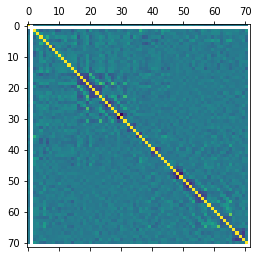

In [266]:
# Look @ correlation Matrix
x_corr = X_train_OLS.corr()
plt.matshow(x_corr)
x_corr

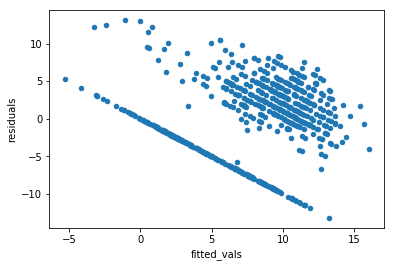

In [267]:
# Residual plot
y_vals.plot(kind='scatter', y='residuals', x='fitted_vals')


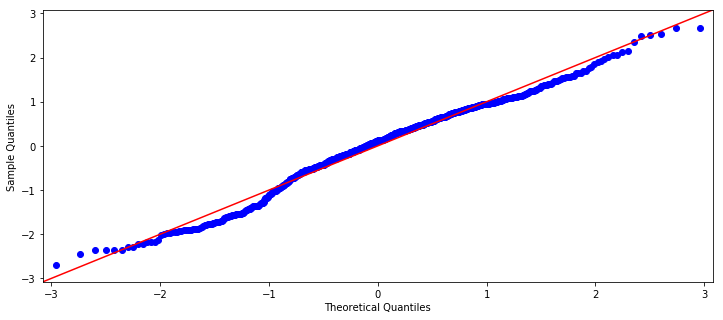

In [268]:
# QQ PLOT
fig, ax = plt.subplots(figsize=(12, 5))
fig = sm.qqplot(stu_resid, line='45', fit=True, ax=ax)

In [269]:
significant_results = results.pvalues[results.pvalues <= 0.05]
signif_coeffs = significant_results.index
signif_coeffs

Index(['math', 'absences', 'school', 'sex', 'famsup', 'paid', 'failures_1',
       'failures_2', 'failures_3'],
      dtype='object')

In [270]:
X_train_OLS = X_train.copy()
y_train_OLS = X_train_OLS['math_G3']
X_train_OLS.drop(['math_G3', 'port_G3'], axis=1, inplace=True)
X_train_OLS['romantic'] = y_train.copy()


X_test_OLS = X_test.copy()
y_test_OLS = X_test_OLS['math_G3']
X_test_OLS.drop(['math_G3', 'port_G3'], axis=1, inplace=True)
X_test_OLS['romantic'] = y_test.copy()

print(X_train_OLS.columns)
print(y_train_OLS)

print(X_test_OLS.columns)
print(y_test_OLS)

Index(['math', 'port', 'age', 'absences', 'school', 'sex', 'address',
       'famsize', 'Pstatus', 'schoolsup', 'famsup', 'paid', 'activities',
       'nursery', 'higher', 'internet', 'Medu_1', 'Medu_2', 'Medu_3', 'Medu_4',
       'Fedu_1', 'Fedu_2', 'Fedu_3', 'Fedu_4', 'Mjob_health', 'Mjob_other',
       'Mjob_services', 'Mjob_teacher', 'Fjob_health', 'Fjob_other',
       'Fjob_services', 'Fjob_teacher', 'reason_home', 'reason_other',
       'reason_reputation', 'guardian_mother', 'guardian_other',
       'traveltime_2', 'traveltime_3', 'traveltime_4', 'studytime_2',
       'studytime_3', 'studytime_4', 'failures_1', 'failures_2', 'failures_3',
       'famrel_2', 'famrel_3', 'famrel_4', 'famrel_5', 'freetime_2',
       'freetime_3', 'freetime_4', 'freetime_5', 'goout_2', 'goout_3',
       'goout_4', 'goout_5', 'Dalc_2', 'Dalc_3', 'Dalc_4', 'Dalc_5', 'Walc_2',
       'Walc_3', 'Walc_4', 'Walc_5', 'health_2', 'health_3', 'health_4',
       'health_5', 'romantic'],
      dtype='object')


In [271]:
# Train
#X_train_OLS = sm.add_constant(X_train_OLS)
X_train_OLS['constant'] = 1


model = sm.OLS(y_train_OLS, X_train_OLS)
results = model.fit()

fitted_vals = results.predict(X_train_OLS)
stu_resid = results.resid_pearson
residuals = results.resid
#y_vals = pd.DataFrame({'residuals':residuals, 'fitted_vals':fitted_vals, 'stu_resid': stu_resid})
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                math_G3   R-squared:                       0.427
Model:                            OLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                     6.080
Date:                Wed, 13 Feb 2019   Prob (F-statistic):           2.13e-36
Time:                        12:55:04   Log-Likelihood:                -1883.3
No. Observations:                 643   AIC:                             3909.
Df Residuals:                     572   BIC:                             4226.
Df Model:                          70                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
math                  7.9526      0.93

In [272]:
significant_results = results.pvalues[results.pvalues <= 0.05]
signif_coeffs = significant_results.index
signif_coeffs

Index(['math', 'absences', 'school', 'sex', 'famsup', 'paid', 'freetime_2',
       'freetime_3', 'freetime_5', 'Dalc_4'],
      dtype='object')

In [275]:
X_train_OLS = X_train.copy()
y_train_OLS = (X_train_OLS['math_G3'] + X_train_OLS['math_G3']
X_train_OLS.drop(['math_G3', 'math'], axis=1, inplace=True)
X_train_OLS['romantic'] = y_train.copy()


X_test_OLS = X_test.copy()
y_test_OLS = X_test_OLS['math_G3']
X_test_OLS.drop(['math_G3'], axis=1, inplace=True)
X_test_OLS['romantic'] = y_test.copy()

print(X_train_OLS.columns)
print(y_train_OLS)

print(X_test_OLS.columns)
print(y_test_OLS)

Index(['port', 'port_G3', 'age', 'absences', 'school', 'sex', 'address',
       'famsize', 'Pstatus', 'schoolsup', 'famsup', 'paid', 'activities',
       'nursery', 'higher', 'internet', 'Medu_1', 'Medu_2', 'Medu_3', 'Medu_4',
       'Fedu_1', 'Fedu_2', 'Fedu_3', 'Fedu_4', 'Mjob_health', 'Mjob_other',
       'Mjob_services', 'Mjob_teacher', 'Fjob_health', 'Fjob_other',
       'Fjob_services', 'Fjob_teacher', 'reason_home', 'reason_other',
       'reason_reputation', 'guardian_mother', 'guardian_other',
       'traveltime_2', 'traveltime_3', 'traveltime_4', 'studytime_2',
       'studytime_3', 'studytime_4', 'failures_1', 'failures_2', 'failures_3',
       'famrel_2', 'famrel_3', 'famrel_4', 'famrel_5', 'freetime_2',
       'freetime_3', 'freetime_4', 'freetime_5', 'goout_2', 'goout_3',
       'goout_4', 'goout_5', 'Dalc_2', 'Dalc_3', 'Dalc_4', 'Dalc_5', 'Walc_2',
       'Walc_3', 'Walc_4', 'Walc_5', 'health_2', 'health_3', 'health_4',
       'health_5', 'romantic'],
      dtype='object

In [276]:
# Train
#X_train_OLS = sm.add_constant(X_train_OLS)
X_train_OLS['constant'] = 1


model = sm.OLS(y_train_OLS, X_train_OLS)
results = model.fit()

fitted_vals = results.predict(X_train_OLS)
stu_resid = results.resid_pearson
residuals = results.resid
#y_vals = pd.DataFrame({'residuals':residuals, 'fitted_vals':fitted_vals, 'stu_resid': stu_resid})
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                math_G3   R-squared:                       0.631
Model:                            OLS   Adj. R-squared:                  0.585
Method:                 Least Squares   F-statistic:                     13.94
Date:                Wed, 13 Feb 2019   Prob (F-statistic):           2.95e-85
Time:                        12:57:02   Log-Likelihood:                -1742.1
No. Observations:                 643   AIC:                             3626.
Df Residuals:                     572   BIC:                             3943.
Df Model:                          70                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
port                  5.6490      2.19

In [183]:
model = LogisticRegression()
model.fit(X_train, y_train)

/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [184]:
def rss(y, y_hat):
    return np.mean((y  - y_hat)**2)

In [186]:
y_hat_probs = model.predict_proba(X_test)[:, 1]

threshold = 0.5

y_hat = (y_hat_probs >= threshold).astype(int)

mse = rss(y_test, y_hat)
print("MSE for LogisticRegression: {}".format(mse))

MSE for LogisticRegression: 0.35403726708074534


0.6459627329192547


Text(33.0, 0.5, 'Actual classes')

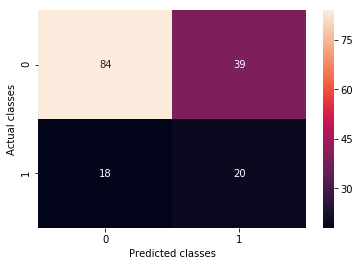

In [205]:
# MODEL EVALUATION
print(accuracy_score(y_hat, y_test.values))

# PLOT THE CONFUSION Matrix
cfm = confusion_matrix(y_hat, y_test.values)
sns.heatmap(cfm, annot=True)
plt.xlabel('Predicted classes')
plt.ylabel('Actual classes')

In [206]:
y_hat_probs = model.predict_proba(X_test)[:, 1]

threshold = 0.7

y_hat = (y_hat_probs >= threshold).astype(int)

mse = rss(y_test, y_hat)
print("MSE for LogisticRegression: {}".format(mse))

MSE for LogisticRegression: 0.3416149068322981


0.6583850931677019


Text(33.0, 0.5, 'Actual classes')

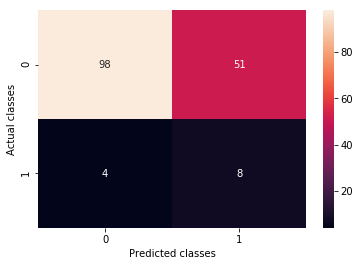

In [207]:
# MODEL EVALUATION
print(accuracy_score(y_hat, y_test.values))

# PLOT THE CONFUSION Matrix
cfm = confusion_matrix(y_hat, y_test.values)
sns.heatmap(cfm, annot=True)
plt.xlabel('Predicted classes')
plt.ylabel('Actual classes')

In [235]:
y_hat_probs = model.predict_proba(X_test)[:, 1]

threshold = 0.67

y_hat = (y_hat_probs >= threshold).astype(int)

mse = rss(y_test, y_hat)
print("MSE for LogisticRegression: {}".format(mse))

MSE for LogisticRegression: 0.32298136645962733


Model Accuracy: 0.6770186335403726


Text(33.0, 0.5, 'Actual classes')

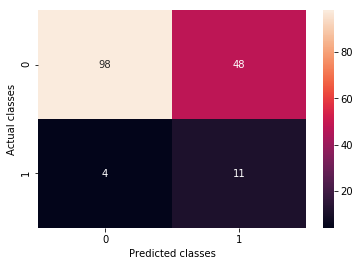

In [236]:
# MODEL EVALUATION
print("Model Accuracy: {}".format(accuracy_score(y_hat, y_test.values)))

# PLOT THE CONFUSION Matrix
cfm = confusion_matrix(y_hat, y_test.values)
sns.heatmap(cfm, annot=True)
plt.xlabel('Predicted classes')
plt.ylabel('Actual classes')

In [187]:
def cv(X, y, base_estimator, n_folds, random_seed=154):
    """Estimate the in and out-of-sample error of a model using cross validation.
    
    Parameters
    ----------
    
    X: np.array
      Matrix of predictors.
      
    y: np.array
      Target array.
      
    base_estimator: sklearn model object.
      The estimator to fit.  Must have fit and predict methods.
      
    n_folds: int
      The number of folds in the cross validation.
      
    random_seed: int
      A seed for the random number generator, for repeatability.
    
    Returns
    -------
      
    train_cv_errors, test_cv_errors: tuple of arrays
      The training and testing errors for each fold of cross validation.
    """
    kf = KFold(n_splits=n_folds, random_state=random_seed)
    test_cv_errors, train_cv_errors = np.empty(n_folds), np.empty(n_folds)
    for idx, (train, test) in enumerate(kf.split(X_train)):
        # Split into train and test
        X_cv_train, y_cv_train = X[train], y[train]
        X_cv_test, y_cv_test = X[test], y[test]
        
        # Standardize data.
        #standardizer = XyScaler()
        #standardizer.fit(X_cv_train, y_cv_train)
        #X_cv_train_std, y_cv_train_std = standardizer.transform(X_cv_train, y_cv_train)
        #X_cv_test_std, y_cv_test_std = standardizer.transform(X_cv_test, y_cv_test)
        
        # Fit estimator
        estimator = clone(base_estimator)
        estimator.fit(X_cv_train, y_cv_train)
        # Measure performance
        y_hat_train = estimator.predict(X_cv_train)
        y_hat_test = estimator.predict(X_cv_test)
        # Calclate the error metrics
        train_cv_errors[idx] = rss(y_cv_train, y_hat_train)
        test_cv_errors[idx] = rss(y_cv_test, y_hat_test)
    return train_cv_errors, test_cv_errors

In [188]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler


class XyScaler(BaseEstimator, TransformerMixin):
    """Standardize a training set of data along with a vector of targets.  """
    
    def __init__(self):
        self.X_scaler = StandardScaler()
        self.y_scaler = StandardScaler()
        
    def fit(self, X, y, *args, **kwargs):
        """Fit the scaler to data and a target vector."""
        self.X_scaler.fit(X)
        self.y_scaler.fit(y.reshape(-1, 1))
        return self
    
    def transform(self, X, y, *args, **kwargs):
        """Transform a new set of data and target vector."""
        return (self.X_scaler.transform(X),
                self.y_scaler.transform(y.reshape(-1, 1)).flatten())

In [189]:
n_folds = 10
train_cv_errors, test_cv_errors = cv(X_train.values, y_train.values, 
                                     LogisticRegression(), n_folds=n_folds)

/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will 

In [190]:
print("Training CV error: {:2.2f}".format(train_cv_errors.mean()))
print("Test CV error: {:2.2f}".format(test_cv_errors.mean()))

Training CV error: 0.27
Test CV error: 0.35


In [191]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import pandas as pd

/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


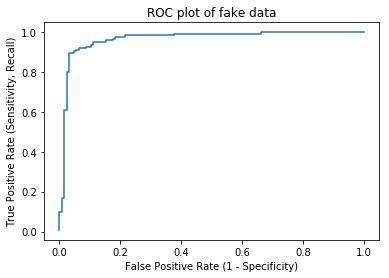

/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


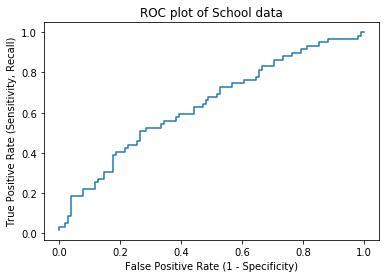

In [192]:
def roc_curve(probabilities, labels):
    '''
    INPUT: numpy array, numpy array
    OUTPUT: list, list, list

    Take a numpy array of the predicted probabilities and a numpy array of the
    true labels.
    Return the True Positive Rates, False Positive Rates and Thresholds for the
    ROC curve.
    '''
    
    thresholds = np.sort(probabilities)

    tprs = []
    fprs = []

    num_positive_cases = sum(labels)
    num_negative_cases = len(labels) - num_positive_cases

    for threshold in thresholds:
        # With this threshold, give the prediction of each instance
        predicted_positive = probabilities >= threshold
        # Calculate the number of correctly predicted positive cases
        true_positives = np.sum(predicted_positive * labels)
        # Calculate the number of incorrectly predicted positive cases
        false_positives = np.sum(predicted_positive) - true_positives
        # Calculate the True Positive Rate
        tpr = true_positives / float(num_positive_cases)
        # Calculate the False Positive Rate
        fpr = false_positives / float(num_negative_cases)

        fprs.append(fpr)
        tprs.append(tpr)

    return tprs, fprs, thresholds.tolist()


def run_fake_data():
    X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                               n_clusters_per_class=2, n_samples=1000)
    X_train, X_test, y_train, y_test = train_test_split(X, y)

    model = LogisticRegression()
    model.fit(X_train, y_train)
    probabilities = model.predict_proba(X_test)[:, 1]

    tpr, fpr, thresholds = roc_curve(probabilities, y_test)

    plt.plot(fpr, tpr)
    plt.xlabel("False Positive Rate (1 - Specificity)")
    plt.ylabel("True Positive Rate (Sensitivity, Recall)")
    plt.title("ROC plot of fake data")
    plt.show()

def run_data(X_train, X_test, y_train, y_test):
    model = LogisticRegression()
    model.fit(X_train, y_train)
    probabilities = model.predict_proba(X_test)[:, 1]

    tpr, fpr, thresholds = roc_curve(probabilities, y_test)

    plt.plot(fpr, tpr)
    plt.xlabel("False Positive Rate (1 - Specificity)")
    plt.ylabel("True Positive Rate (Sensitivity, Recall)")
    plt.title("ROC plot of School data")
    plt.show()




run_fake_data()
run_data(X_train, X_test, y_train, y_test)

In [101]:
def rmse(theta, thetahat):
    ''' Compute Root-mean-squared-error '''
    return np.sqrt(np.mean((theta - thetahat) ** 2))

In [102]:
def calc_linear():
    # Fit your model using the training set
    linear = LinearRegression()
    linear.fit(X_train, y_train)

    # Call predict to get the predicted values for training and test set
    train_predicted = linear.predict(X_train)
    test_predicted = linear.predict(X_test)

    # Calculate RMSE for training and test set
    trainErr = rmse(y_train, train_predicted)
    valErr = rmse(y_test, test_predicted)

    return (trainErr, valErr)

In [ ]:
#Part 3
def k_fold_linear():
    ''' Returns error for k-fold cross validation. '''
    err_linear, index, num_folds = 0, 0, 5
    kf = KFold(n_splits= num_folds)
    error = np.empty(num_folds)
    linear = LinearRegression()
    for train, test in kf.split(X_train):
        linear.fit(X_train[train], y_train[train])
        pred = linear.predict(X_train[test])
        error[index] = rmse(pred, y_train[test])
        index += 1

    return np.mean(error)

In [ ]:
def plot_learning_curve(estimator, label=None):
    ''' Plot learning curve with varying training sizes'''
    scores = list()
    train_sizes = np.linspace(10,100,10).astype(int)
    for train_size in train_sizes:
        cv_shuffle = model_selection.ShuffleSplit(train_size=train_size, 
                        test_size=200, random_state=0)
        test_error = model_selection.cross_val_score(estimator, X, y, cv=cv_shuffle)
        scores.append(test_error)

    plt.plot(train_sizes, np.mean(scores, axis=1), label=label or estimator.__class__.__name__)
    plt.ylim(0,1)
    plt.title('Learning Curve')
    plt.ylabel('Explained variance on test set (R^2)')
    plt.xlabel('Training test size')
    plt.legend(loc='best')
    plt.show()

In [ ]:
def plot_errors():
    ''' Plot errors from test and training sets '''
    m = X.shape[1]
    err_test, err_train = [], []
    linear = LinearRegression()
    for ind in range(m):
        linear.fit(X_train[:,:(ind+1)], y_train)

        train_pred = linear.predict(X_train[:,:(ind + 1)])
        test_pred = linear.predict(X_test[:,:(ind + 1)])

        err_test.append(rmse(test_pred, y_test))
        err_train.append(rmse(train_pred, y_train))

    x = range(1, m+1)
    plt.figure()
    plt.plot(x, err_test, label='Test error')
    plt.plot(x, err_train, label='Training error')
    plt.title('Errors')
    plt.ylabel('RMSE')
    plt.xlabel('Features')
    plt.legend()
    plt.show()

In [ ]:
#Part 4
def adj_r2(X, predictors, r2):
    sampleSize = len(X)
    num = (1-r2)*(sampleSize - 1)
    den = sampleSize - predictors - 1
    return 1 - (num/den)

In [ ]:
def rfe():
    score = np.zeros(len(colNames)+1)
    for i in range(1, len(colNames)+1):
        est = LinearRegression()
        selector = RFE(est, i).fit(X_train, y_train)
        score[i] = adj_r2(X_train, i, selector.score(X_test, y_test))
    plt.figure()
    plt.plot(np.arange(1, len(score)+1), score)
    plt.title('Adjusted R^2 vs. Feature Count')
    plt.xlabel('Number of features')
    plt.ylabel('Adjusted R^2')
    plt.legend()
    plt.show()

In [ ]:
class forward_select(object):
    def __init__(self, verbose=True):
        self.verbose = verbose
        self.best_score = 0.
        self.column_names = []
        self.keep = []
        self.X_orig = None
        self.X = None
        self.y = None

    def fit_transform(self, df, target):
        self.y = target
        self.column_names = df.columns.tolist()
        self.X_orig = df.values
        self.X = np.ones([self.X_orig.shape[0],1])
        
        while self.X_orig.shape[1] > 0:
            scores = []
            for feature in range(self.X_orig.shape[1]):
                X_temp = np.concatenate((self.X, self.X_orig[:, feature, None]), axis=1)
                scores.append(sm.OLS(self.y, X_temp).fit().rsquared_adj)
            best_idx = np.argmax(np.asanyarray(scores))

            if scores[best_idx] <= self.best_score:
                if self.verbose: 
                	print('Removed columns ->', self.column_names)
                	print('-> All done!')
                return self.X[:,1:]
            else:
                self.X = np.concatenate((self.X, self.X_orig[:, best_idx, None]), axis=1)
                self.X_orig = np.delete(self.X_orig, best_idx, axis=1)
                self.keep.append(self.column_names.pop(best_idx))
                self.best_score = scores[best_idx]
                if self.verbose: print('Kept \'%s\' for a best score of %s' % (self.keep[-1], self.best_score))

In [ ]:
def gen_forward():
    df = pd.DataFrame(X, columns=colNames)
    forward = forward_select(verbose=True)
    forward.fit_transform(df, y)

In [ ]:
print('--- Part 2 ---')
print('One-fold Cross Validation')
print('(Training error, Validation error) = ', calc_linear())

print('--- Part 3 ---')
print('K-fold Cross Validation')
print('K-fold error:', k_fold_linear())
estimator = LinearRegression()
plot_learning_curve(estimator, label='LinearRegression')
plot_errors()

print('--- Part 4 ---')
rfe()
gen_forward()